# **Homework 4 - Movie Recommendation System**

*Group#13*

- **Marco Zimmatore** - [zimmatore.1947442@studenti.uniroma1.it](mailto:zimmatore.1947442@studenti.uniroma1.it)
- **Piercarlo Risi** - [risi.1914164@studenti.uniroma1.it](mailto:Risi.1914164@studenti.uniroma1.it)
- **Mattia Visciglio** - [visciglio.1914536@studenti.uniroma1.it](mailto:visciglio.1914536@studenti.uniroma1.it)
- **Laura Moreno** - [la.morenorod@gmail.com](mailto:la.morenorod@gmail.com)

___

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import warnings
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
warnings.filterwarnings("ignore")

## **1. Recommendation System with LSH**
___

### **1.1 Data preparation** 
Explore the dataset to understand the structure and identify any preprocessing steps needed.

#### **Exploring the Dataset**
We load into two Dataframes the content of the *CSV* files `rating.csv` and `movie.csv`, that will be crucial to build our Reccomender System.

In [2]:
movies_dir = "archive/movie.csv"
dataset_movies = pd.read_csv(movies_dir)
dataset_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


> Printing the dataframe, we can see that some rows have the expression *(no genres listed)* in the `genres` column

In [3]:
dataset_movies[dataset_movies["genres"] == "(no genres listed)"]

,movieId,title,genres
16574,83773,Away with Words (San tiao ren) (1999),(no genres listed)
16589,83829,Scorpio Rising (1964),(no genres listed)
16764,84768,Glitterbug (1994),(no genres listed)
17080,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
17243,87061,Trails (Veredas) (1978),(no genres listed)
...,...,...,...
27216,131082,Playground (2009),(no genres listed)
27229,131108,The Fearless Four (1997),(no genres listed)
27258,131166,WWII IN HD (2009),(no genres listed)
27261,131172,Closed Curtain (2013),(no genres listed)


> We replace the string *(no genres listed)* with an empty string

In [4]:
# We use the Pandas built-in function loc to set the values of the column genres that match the search to empty string
dataset_movies.loc[dataset_movies["genres"] == "(no genres listed)", "genres"] = ""
dataset_movies.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


> For our purposes, it's also useful to load the content of the *Rating* dataset, which will help us to solve the following exercises.

In [5]:
# We open and load in a new Dataframe the content of the CSV file.
rating_dir = 'archive/rating.csv'
dataset_ratings = pd.read_csv(rating_dir)
dataset_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


We merge the two datasets in order to compute a uniform analysis using the Pandas function `merge()`.
We know that each `movieId` from the *ratings* dataset corresponds to one and only `movieId` value from the *movies* dataset which is a *primary_key*.

- You can notice that we dont specify a Merge type (left, right, ...) because we wanna mantain only the rated movies for our recommender system.

In [6]:
dataset_movies_ratings = pd.merge(dataset_movies, dataset_ratings, on = "movieId")
dataset_movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41


Before going deep with the exercise, we conduct the **Exploratory Data Analysis** to deepen the understanding of the two databases

> We print the shape of the DataFrame 

In [7]:
dataset_movies_ratings.shape

(20000263, 6)

The Shape of the merged DataFrame  mantains the number of rows of the longest between the two DataFrames.

> We print the column's names

In [8]:
list(dataset_movies_ratings.columns)

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

> We check the Data Types of each column

In [9]:
dataset_movies_ratings.dtypes

movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp     object
dtype: object

> Seen that the column timestamp is detected as *Object*, we convert it to *timestamp*

In [10]:
dataset_movies_ratings['timestamp'] = pd.to_datetime(dataset_movies_ratings['timestamp'])
dataset_movies_ratings.dtypes

movieId               int64
title                object
genres               object
userId                int64
rating              float64
timestamp    datetime64[ns]
dtype: object

> We check if there are Nan values in the columns

In [11]:
# We filter the columns only for the columns that have at least 1 null value
list(dataset_movies_ratings.columns[dataset_movies_ratings.isnull().sum() > 0])

[]

> We check if there are any duplicates through the function `duplicated()` that returns *True* or *False* if the row is duplicated. Filtering by row, we obtain a DataFrame containing all the duplicated rows

In [12]:
# List of Rows Duplicated
dataset_movies_ratings[dataset_movies_ratings.duplicated()]

,movieId,title,genres,userId,rating,timestamp


There are no duplicates in the DataFrame.

> What's the number of the users who have rated a movie?

In [13]:
dataset_movies_ratings["userId"].nunique()

138493

#### **Tabular Summary**

We calculate statistics like mean, median, minimum through the Pandas function `describe()` and explore how data is distributed.

In [14]:
dataset_movies_ratings.describe()

,movieId,userId,rating,timestamp
count,2.000026e+07,2.000026e+07,2.000026e+07,20000263
mean,9.041567e+03,6.904587e+04,3.525529e+00,2004-11-20 02:32:01.677117568
min,1.000000e+00,1.000000e+00,5.000000e-01,1995-01-09 11:46:44
25%,9.020000e+02,3.439500e+04,3.000000e+00,2000-08-20 18:55:45
50%,2.167000e+03,6.914100e+04,3.500000e+00,2004-12-20 15:18:06
75%,4.770000e+03,1.036370e+05,4.000000e+00,2008-11-02 16:11:57.500000
max,1.312620e+05,1.384930e+05,5.000000e+00,2015-03-31 06:40:02
std,1.978948e+04,4.003863e+04,1.051989e+00,NaN


We can notice that only the Numeric columns are integrated in the summary. The tabular summary of the dataset is pretty useless, because the column `movieId` is a *primary_key* and it's a categorical-like identifier. The column *rating* is the only numeric column where these statistics are actually valuable:

- `mean`: The average rating is 3.53, indicating that users generally rate movies slightly above the midpoint of the 0.5 to 5 rating scale.

- `std`: A standard deviation of 1.05 suggests moderate variability in the ratings.

- `Percentiles`:
    - The median (50%) is 3.5, aligning with the mean.
    - 75% of ratings are below 4, suggesting fewer very high ratings.

#### **Visualization**

The last step of Exploring the Dataset is to visualize the data.


To  visualize the distribution of movie ratings across all users we use a *box plot*. 
A box plot provides a summary of a set of data values through their quartiles, and it can help visualize the spread of the ratings and identify any potential outliers.

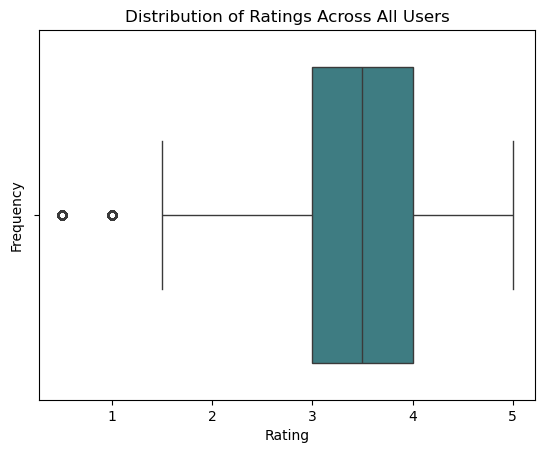

In [15]:
sns.boxplot(x='rating', data=dataset_movies_ratings, color='lightgreen', palette='crest')
plt.title('Distribution of Ratings Across All Users')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show();

> We can notice by the boxplot that the majority of the user have rated movies between 3 and 4, confirming the previous results given by the tabular summary that computed a mean of 3.5. We also mention the presence of some outliers
___

The following *plot* outputs the number of rating over time per each month in every date we find in the dataset. We use the `resample("M", on = "timestamp")` to group data by month using the `timestamp` column and counting all the ratings done in the same month.

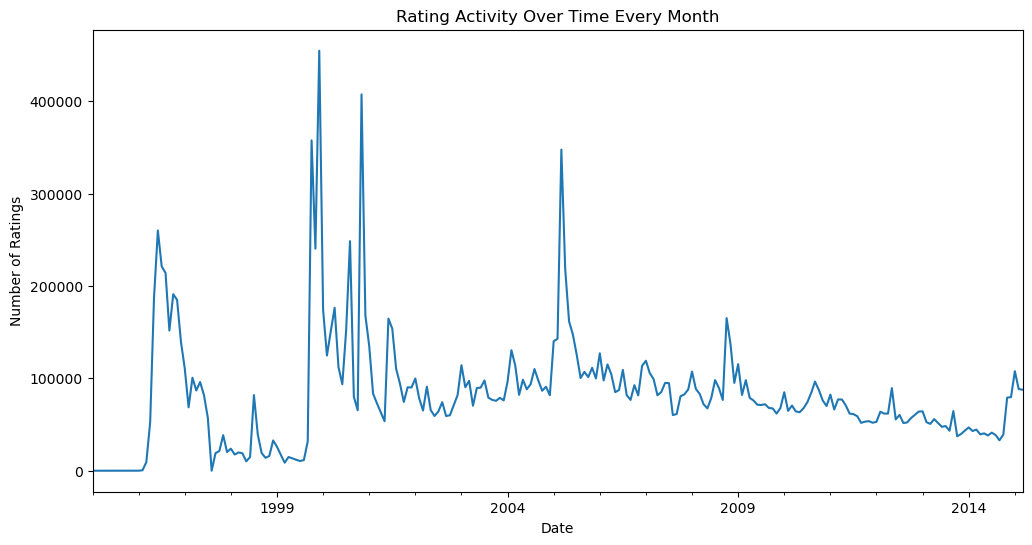

In [16]:
# Resample data by Month and count the number of ratings
rating_counts = dataset_movies_ratings.resample('M', on='timestamp').size()

# Plot time series of rating activity
plt.figure(figsize=(12, 6))
rating_counts.plot()
plt.title('Rating Activity Over Time Every Month')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()


> We see that in the year 2000, we had the most ratings in the dataset, reaching over *400 000* ratings submitted. We have to mention a slow descrease of the ratings aftert the 2005 peaks.
___

In the end, we create an heatmap of the ratings taking into account 20 random users and 20 random movies (for computational issues) through the function `sample()`. We analyse with an *heatmap* the value of the rating done by the user to the movie and we assign a color based on the rating's value.

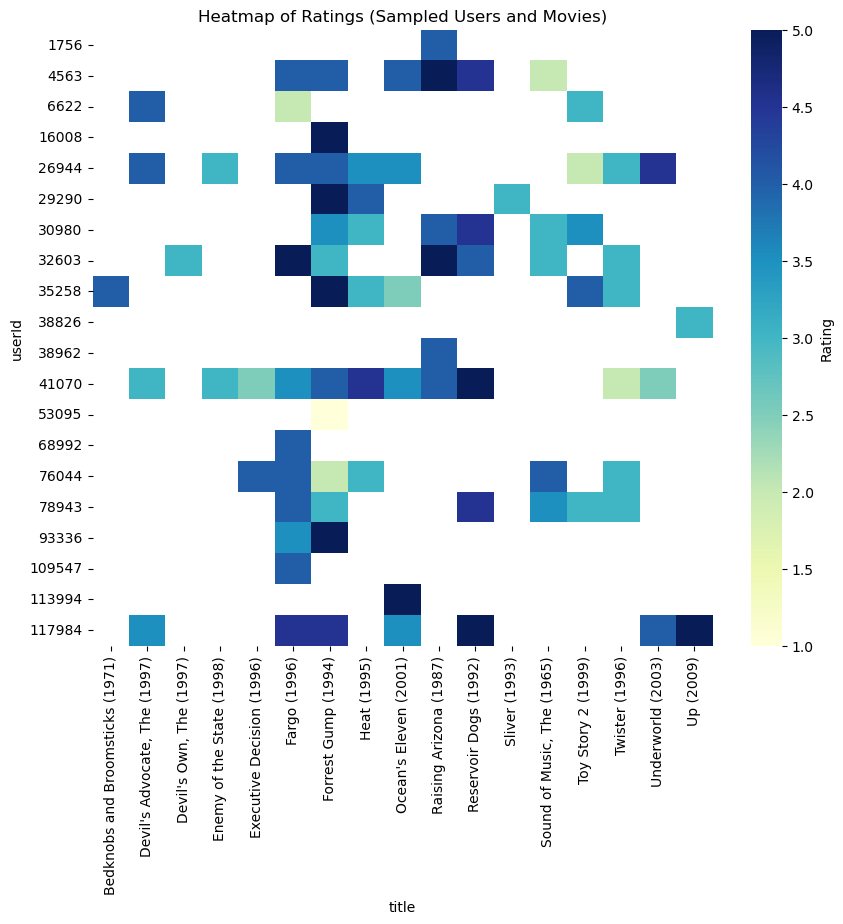

In [17]:
# Sample 1000 random users and 20 random movies
sampled_users = dataset_movies_ratings['userId'].sample(20).unique()
sampled_movies = dataset_movies_ratings['title'].sample(20).unique()

# Create the user-item rating matrix (with NaN for missing ratings)
rating_matrix = dataset_movies_ratings[dataset_movies_ratings['userId'].isin(sampled_users) &
                                        dataset_movies_ratings['title'].isin(sampled_movies)]
rating_matrix = rating_matrix.pivot(index='userId', columns='title', values='rating')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rating_matrix, cmap="YlGnBu", fmt='.1f', cbar_kws={'label': 'Rating'})
plt.title('Heatmap of Ratings (Sampled Users and Movies)')
plt.show()


> We notice that darker the colors are for that *movie* (column), and better ratings thay will have from each user (row) 

___

### **1.2 Minhash Signatures**

Using the `userId` and `movieId` columns, implement your own **MinHash function**. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

In [18]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/piercarlorisi/Desktop/Algorithmic methods of data mining/ADM-HW4/functions.py'>

- Before applying the `LSH` algorithm, we have to create the *signature matrix*, which provides a structured way to represent user-item interactions, serving as the foundation for various collaborative filtering and matrix factorization techniques. In our case, we will have matrix where each row represent the unique *movies* and each columns the unique *users*.


**Function** `createBinaryMatrix`:

- Extract unique users and movies:

    - Identify all unique `userIds` and `movieIds` from the dataset.
    - These represent the rows (movies) and columns (users) of the binary matrix.

- Create mappings:
    - Map each userId and movieId to a corresponding index using Python dictionaries.

- Initialize the binary matrix:

    - Construct a 2D numpy array with dimensions [`number of movies`] x [`number of users`].
    - All entries are initialized to 0.

- Populate the matrix:

    - Iterate through each row in the DataFrame.
    - For each (`userId`, `movieId`) pair, set the corresponding matrix cell to 1, indicating interaction, 0 otherwise.

In [25]:
characteristic_matrix = functions.createBinaryMatrix(dataset_movies_ratings)

Now that we have the `characteristic_matrix`, we can compute the MinHash `signature_matrix` through our custom *MinHashFunction*.

- The goal of the **MinHash** is to replace a large set with a smaller "signature" that still preserves the underlying similarity metric.

**Function** `MinHashFunction`:


- Initialize Parameters:

    - `num_movies`: Number of rows in the characteristic matrix.
    - `num_users`: Number of columns in the characteristic matrix.
    - `k`: Total number of rows (used as a prime modulus in hash functions).
    - `num_groups`: Number of row groups, determined by m (rows per group).

- Signature Matrix Initialization:

    - Initialize a signature matrix of size [num_hashes * num_groups, num_users].
    - Set all entries to infinity (np.inf) to later find the minimum hash values.

- Create Random Hash Functions:

    - Generate num_hashes hash functions using the formula $h(x)=(a⋅x+b)%p$, where:
        - `a` and `b` are random coefficients.
        - `p` is the number of rows (`k`).

- Group-Wise Processing:

    - Process rows in groups of size `m` to reduce memory overhead, hence we wanna optimize the MinHash Function.

    - For each group:
        - Extract the relevant rows from the characteristic matrix.

- Compute Row Hashes:

    - For each hash function:
        - Compute hash values for rows in the current group.
        - For each user:
            - Check if the user has interacted with any item in the group (if the column has a 1).
            - Find the minimum hash value among the active rows (`row_hashes` for rows with 1 in the user column).
            - Update the corresponding signature matrix entry with the minimum value.

In [26]:
signature_matrix = functions.MinHashFunction(num_hashes = 2, characteristic_matrix = characteristic_matrix, m = 10)

> Notice that we have chosen $m = 10$ and $num\_ashes = 2$ during the function call

___
- Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.


### **1.3 Locality-Sensitive Hashing (LSH)**
Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

1. **Bucket Creation**: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.
    - **Debugging Tip**: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.


> Since we have built our **MinHash Signature Matrix**, we can apply the *LSH* algorithm in order to classify each user to a bucket so that users that have rated common movies belong to similar buckets.

**Function** `lsh_user_movies`:

- Calculate Rows per Band:

    - The number of rows in each band is calculated by dividing the total number of rows of the signature_matrix (num_hashes * num_movies) by the number of bands (num_bands).

- Loop Over Bands:

    - For each band we identify `start_row` and `end_row` of the signature_matrix belonging to the current band

- Process Each User:
    - For each user we compute *Band Signature*:
        - A tuple called `band_signature` is created from the user's hash values in this band

- Hash into Buckets:
    - Users with the same band_signature are grouped into the same bucket.

In [27]:
buckets = functions.lsh_user_movies(signature_matrix, num_bands = 3)

> `buckets` will contain a dictionary key, value where the key are represented by tuples of hashes of the signature_matrix and their size will be `rows_per_band`, while the value will be the list of userId indexes that belong to that band. 

2. **Query**: For a given user, identify the **two most similar** users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.




> Now that we have the *buckets* dictionary, retrieving similar users becomes very simple, because they will be in the same bucket of the input user.

**Function** `query_similar_users`:

- We search the most similar users in the same bucket of the `user_index`, defining a Set and discarding the user_index

- Then we compute the **Jaccard Similarity** between the columns of the *signature matrix*, representing the hash_values for each *similar_userId* and we sort the users based on the similarity.

- We return a list of candidate users index


In [28]:
user_index = 1
similar_users = functions.query_similar_users(user_index, buckets, signature_matrix)

3. **Movie Recommendation Logic**:

    - If both similar users have rated a movie, recommend this movie based on the **average rating**.
    
    - If there are no commonly rated movies, recommend the top-rated movies of the most similar user.
    
4. **Final Recommendation**: Provide at most five movies to the user.

> To compute the recommended movies, we will recommend firstly the common movies by the similar users based on aveage rating and then the top-rated ones.

**Function** `recommend_movies`

- Firstly, we add to the list of recommended movies the common movies rated by the similar users that have that highest average ratings.

- If the length of the lsit of recommended movies is not enough (less than *max_recommendation*), we select the highest rated movies by similar users

- We select the most similar user (remember the the list `similar_users` was sorted on similarity)

- We select all the movies rated by this user, sorting them by rating, and add them to the list_of_recommended_movies until its length is equal to *max_recommendation*

In [29]:
user_movie_ratings = dataset_movies_ratings[["userId","movieId", "title", "rating"]]
recommendations = functions.recommend_movies(similar_users, user_movie_ratings)
recommendations

,Movies Recommended,Rating
0,Apollo 13 (1995),5.00
1,Forrest Gump (1994),5.00
2,Dave (1993),5.00
3,Braveheart (1995),4.75
4,Philadelphia (1993),4.75


## **2. Grouping Movies Together!**
___
In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.


### **2.1 Feature Engineering**

As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. `movieid` id of each movie
2. `genres` list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
3. `ratings_avg` the average ratings provided by users for the movie
4. `relevant_genome_tag` the most relevant tag to the movie given in the genome set
5. `common_user_tag` the most common tag given to the movie by the users

In addition to the above features, include **at least three additional** features for clustering.





In [19]:
# inizialize new_dataframe with 4 columns:
# movieId,	title,	genres,	rating
from functions import new_order
new_dataset = new_order(dataset_movies_ratings)

> We create the column `ratings_avg` for the *new_dataset*. 

After this step our dataframe will have just one row for each movie and during all the process to create our final dataframe we keep it clean from empty cells.

In [20]:
from functions import average_ra
# here we crate the avarage score column for the new_dataframe
new_dataset = average_ra(new_dataset)

> Now we give a mean genre for each film and choose at most 2 words for genre.

The criterio for assign new and reductive genre is the following:
1. having all those genres we take just the main one;
2. we build it like: if there are 'adventure' and 'aciton', we create 'action adveture'.

In [21]:
from functions import representative_genre
# create the column
new_genres = new_dataset['genres'].apply(lambda x: representative_genre(x))
# add it 
new_dataset["genres"] = new_genres


> we read the file genome_tags.csv and genome_scores.csv and create the column `relevant_genome_tag`

In [22]:
from functions import read_gen_tag, read_gen_score, relevant_genome
# in the next 3 lines we prepare the dataset_tag,
dataset_genome_tags = read_gen_tag()
dataset_genome_score = read_gen_score()
dataset_tag = pd.merge(dataset_genome_score,dataset_genome_tags, on='tagId')
# for choosing the most relevant tag we took the one with highest relevance
new_dataset = relevant_genome(new_dataset,dataset_tag)

> Create and add the `common_user_tagn` column

In [23]:
from functions import get_max_occuring_tags, common_column, read_common 
# 2 lines: read the file and create the column
person_tag = read_common()
common_user_tag = common_column(person_tag)
# select the tagId with max occurences for each movieId and
# add the column to new_dataframe
new_dataset = pd.merge(new_dataset, common_user_tag, on='movieId', how='inner')
new_dataset = new_dataset.rename(columns={'tag_max': 'common_user_tag'})

> we create the column: `release_year`.

So we split the year from the titles

In [24]:
from functions import extract_numbers_from_title, remove_numbers_from_title
# we work just on 2 columns
title_column =  new_dataset[['movieId', 'title']]
# extract the realese year form the titles
title_column['release_year'] = title_column['title'].apply(extract_numbers_from_title)
# remove the title column to merge just the reales_year
title_column = title_column.drop( columns= ['title'])
# add the column
new_dataset = pd.merge(new_dataset, title_column, on='movieId', how='inner')
# the release_year has terms like [1999], so we leave the square brackets
new_dataset['title'] = new_dataset['title'].apply(remove_numbers_from_title)

> we create two columns: `imdbId` e `tmdbId`, from the link.csv

In [25]:
# read the link.csv
links = "archive/link.csv"
link = pd.read_csv(links)
# remove the empty link for both columns
link = link.dropna()
# add them 
new_dataset = pd.merge(new_dataset, link, on='movieId', how='inner')
new_dataset['release_year'] = new_dataset['release_year'].apply(lambda x: int(x[0]))
new_dataset.head(10)


,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,release_year,imdbId,tmdbId
0,1,Toy Story,children,3.7,toys,Pixar,1995,114709,862.0
1,2,Jumanji,children,2.8,adventure,Robin Williams,1995,113497,8844.0
2,3,Grumpier Old Men,comedy,2.9,good sequel,moldy,1995,113228,15602.0
3,4,Waiting to Exhale,comedy,3.0,women,characters,1995,114885,31357.0
4,5,Father of the Bride Part II,comedy,2.0,good sequel,steve martin,1995,113041,11862.0
5,6,Heat,action,3.7,crime,Al Pacino,1995,113277,949.0
6,7,Sabrina,comedy,3.0,remake,remake,1995,114319,11860.0
7,8,Tom and Huck,children,2.2,adventure,Library System,1995,112302,45325.0
8,9,Sudden Death,action,2.3,action,Jean-Claude Van Damme,1995,114576,9091.0
9,10,GoldenEye,action adventure,2.6,007,007,1995,113189,710.0


> ### *Conclusion:*

We have more than 8 features because there were some of them how had more informations, so splitting them we get a bigger view of the dataset

### **2.2 Choose your features (variables)!**

With multiple features available for the movies, you need to consider the following two questions: 
1. Should you normalize the data or leave it as is? 
2. Should you include all these features, or can you reduce the dimensionality of the data?

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

### Questions
1. Should you normalize the data or leave it as is? 
2. Should you include all these features, or can you reduce the dimensionality of the data?

3. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?

### Answer
Normalize datas means: adjusting the values of numeric features so that they fit within a specific range or distribution. That is usefull because usually the dataset contains features that have very different ranges, so when they are normalized the model may learn more effectively because each feature will contribute more evenly to the model’s decision-making process.
While if all your features are on the same scale and in the same range, there is no need to normalize.

Given that, we exclude: title, imdbId and tmdbId because they are useless for the analyses; we notice that our remaining dataset features are not on the same scale so we normalize it. There are:

>In our dataset we have two variables type: numbers and strings. First we normalize the numbres variables using StandardScaler for the `release_year` column because the range is too large. We use Min-Max for `ratings_avg`column because it is a continuous variable in the interval from 0 to 5.

>While for the rest we normilize just `relevant_genome_tag` and `common_user_tag` because the other do not need it as `movieId` and the links columns that represent specific characters. For the normalization we use OneHotEncoding, that transforms each category of a variable into a new column, where each column represents a category and contains values ​​of 0 or 1.


### Question

4. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.

### Answer 

Data normalization, we use sklearn package for this process

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

Applay StandardScaler to `release_year`

In [27]:
# copy new_dataset 
df_copy = new_dataset.copy()
# column to apply StandardScaler
numerical_features = ['release_year']
# create the transformer for StandardScaler 
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

# create the ColumnTransformer that apply StandardScaler just to release_year
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)], remainder='passthrough')
# apply it
X = preprocessor.fit_transform(df_copy)

# add the name at the column, we lost it during the process
columns = numerical_features + [col for col in df_copy.columns if col not in numerical_features]
# create the dataframe with normalized column 
df_copy = pd.DataFrame(X, columns=columns)

Applay Min-Max to `ratings_avg`

In [28]:
# columns to applay Min-Max
numerical_features = ['ratings_avg']
# create the transformer for MinMaxScaler
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', MinMaxScaler())])
# create the ColumnTransformer that apply Min-Max just to ratings_avg
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)],remainder='passthrough')
# apply it
X = preprocessor.fit_transform(df_copy)
# add the name at the column, we lost it during the process
columns = numerical_features + [col for col in df_copy.columns if col not in numerical_features]
# create the dataframe with normalized column 
df_copy = pd.DataFrame(X, columns=columns)


Apply the normalization for the alphabetical columns: `relevant_genome_tag`, `common_user_tag` and `genres`

In [29]:
# columns to applay OneHotEncoding
categorical_features = ['relevant_genome_tag', 'common_user_tag', 'genres']
# we create the transformer for OneHotEncoding
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])
# create ColumnTransformer that apply OneHotEncoding just to relevant_genome_tag, genres and common_user_tag
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)],remainder='passthrough')
# applay it
X = preprocessor.fit_transform(df_copy)
# we get the column names create by OneHotEncoder
ohe_columns = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)
# joint the new columns names with the not modify columns
columns = list(ohe_columns) + [col for col in df_copy.columns if col not in categorical_features]
# create the dataframe with normalized columns
df_trasformed = pd.DataFrame(X, columns=columns)

### Question
5. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

### Answer
Dimensionality reduction means reduce the variables preserving the most important and meaning information, this is used by machine learning and data analysis. In dataframe contest the dimensionality reduction is referring to reduce the feature so the column, that's usefull to: improve the performance of machine learning models, clustering etc...; better data visualize; speed up computations by making the dataset smaller; prevent overfitting by removing features that are not meaningful or are highly correlated.

The most popular technics for doing dimendionality reduction are: Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), Linear Discriminant Analysis (LDA).
1. PCA works by finding new axes (called principal components) that capture the maximum variance in the data. The first few components will explain most of the variance, allowing us to reduce the dimensionality by selecting only these components. It is a linear technique, meaning it assumes linear relationships between the features.
2. t-SNE is a non-linear dimensionality reduction technique often used for visualizing high-dimensional data. It is particularly useful for data with complex relationships that can't be captured by linear methods like PCA. It is good for visualizing clusters and patterns in data, but it is computationally expensive for large datasets.
3. LDA is a supervised dimensionality reduction technique that seeks to reduce the data's dimensionality while maximizing the separability between different classes. Unlike PCA, which only maximizes variance, LDA maximizes the class separation and is especially useful when the data is labeled.

For our dataframe data structur we do not use the PCA because the data relationship is not linear. The normalization has trasformed relevant_genome_tag, common_user_tag in two big 0,1 matrices, so they are not linear. At the and we choose the t-SNE.

### Question
6.  If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.


### Answer 
Reducing features

In [30]:
# create the dataset for the features reduction 
# to df_trasformed we remove some columns 
# we let there just the 4 normalizated columns 
df_trasformed.drop(columns=['title','imdbId','tmdbId'], inplace=True) 
# prepare the dataframe
lavoro = df_trasformed.copy()
# we exclude release_year and movieId, because they are useless
lavoro = lavoro.drop(columns=['release_year','movieId']) 
print(type(lavoro))
lavoro.head(5)

<class 'pandas.core.frame.DataFrame'>


,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,relevant_genome_tag_abortion,...,genres_film-noir,genres_horror,genres_musical,genres_mystery,genres_romance,genres_sci-fi,genres_thriller,genres_war,genres_western,ratings_avg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711111
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511111
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


Apply the t-SNE 

In [31]:
from sklearn.manifold import TSNE
# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3)
df_tsne_1 = tsne.fit_transform(lavoro)
# Create a DataFrame with the results
df_tsne = pd.DataFrame(df_tsne_1, columns=['Dim1', 'Dim2','Dim3'])
print(df_tsne)


           Dim1       Dim2       Dim3
0     11.080374  22.626169  -3.673923
1     20.142605  17.894882   0.447067
2     21.254370   7.083583   3.430047
3     12.386479  -8.736601   3.124669
4     21.268988   6.869946   3.402479
...         ...        ...        ...
9799  -2.340045   4.725562 -23.581814
9800  21.756519   8.694686 -11.549506
9801   0.367998  27.148291   7.773384
9802  27.308413  -9.608059   9.971857
9803  -1.920448  27.345783  -3.572992

[9804 rows x 3 columns]


### **2.3 Clustering**

Now that you have prepared the data, you can create the clusters.

 >### Question 
 1. How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.



  >### Answer 
1.  Elbow Method


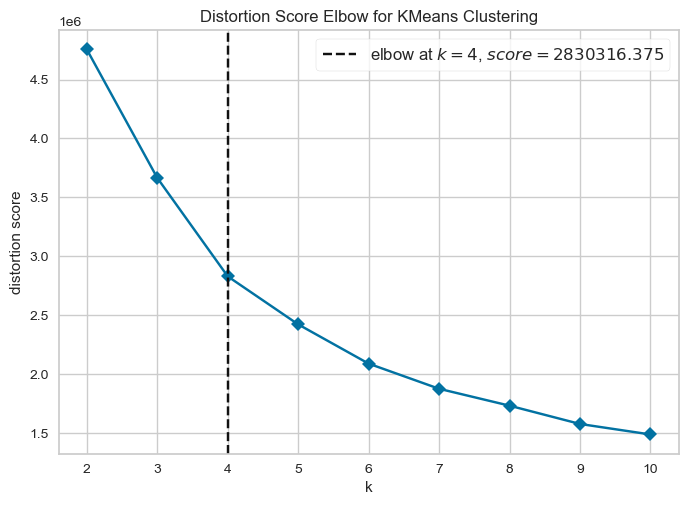

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, timings=False)
visualizer.fit(df_tsne) 
visualizer.show() 

2.  Silhouette Score

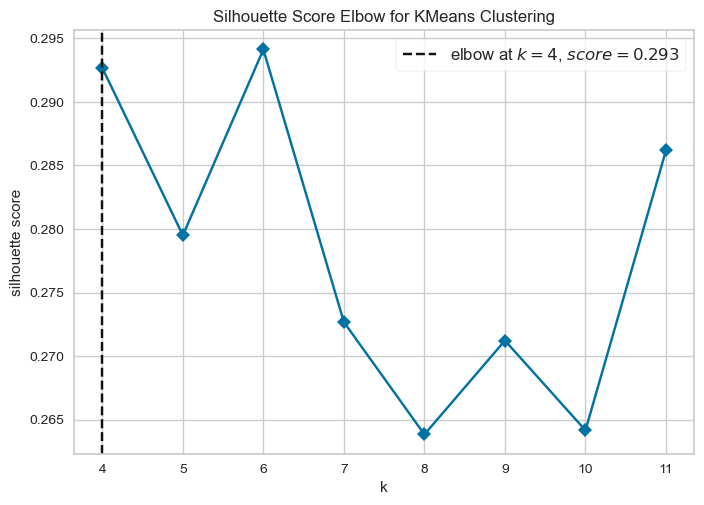

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False)
visualizer.fit(df_tsne) 
visualizer.show() 

 Elbow gives always k=4 while Silhouette Score gives different k for each time you run the code. i do not know why, but i choose k = 4 for the next steps

  >### Question 
 2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.
   >### Answer 
We use the k-means algorithm that we developed in the laboratory


In [34]:
# here we fix the clusters number
cluster_numbers = 4

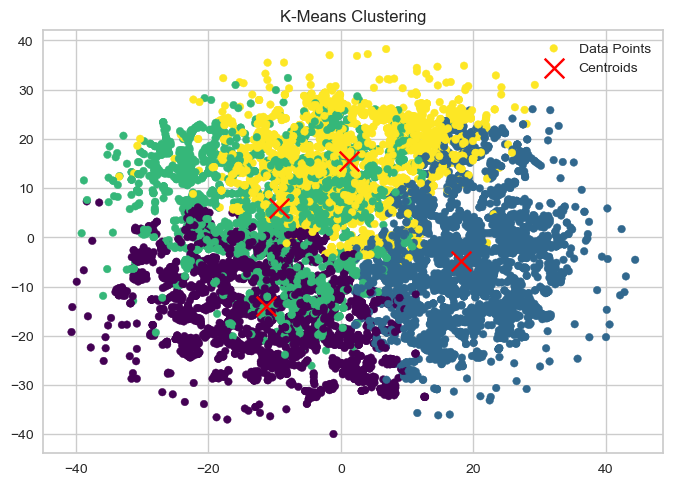

In [35]:

def initialize_centroids(X, k):
    n_samples = X.shape[0]
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]
    return centroids

def assign_clusters(X, centroids):
    distances = np.linalg.norm((X[:, np.newaxis] - centroids).astype(float), axis=2 )
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

def update_centroids(X, cluster_labels, k):
    new_centroids = np.array([X[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def k_means(X, k, max_iters=100, tol=1e-4):
    # Step 1: Initialize centroids
    centroids = initialize_centroids(X, k)

    for i in range(max_iters):
        # Step 2: Assign clusters
        cluster_labels = assign_clusters(X, centroids)

        # Step 3: Update centroids
        new_centroids = update_centroids(X, cluster_labels, k)

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_labels


k = cluster_numbers
X = df_tsne.values
centroids, cluster_labels = k_means(X, k)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=30, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-Means Clustering")
plt.legend()
plt.show()

>### Question 
3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.

>### Answer 
initialize_centroids this function starts with random centroids

Convergence reached after 25 iterations
Final centroids finali:
[[-11.295617  -13.986136    6.529383 ]
 [ 18.173529   -4.735086   -3.0814693]
 [  1.1892543  15.4767065  12.668817 ]
 [ -9.3313055   5.973614  -14.732617 ]]
Final labels for points:
[2 2 1 1 1 2 1 2 2 2]


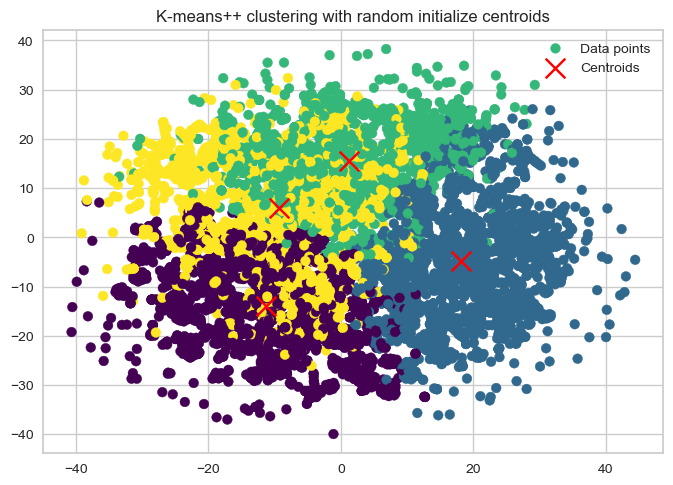

In [36]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def random_initialize_centroids(df, k):
    X =  df.values
    n_samples = X.shape[0]
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]
    return centroids

def kmeans_plus_plus(df, k, max_iters=100):
    centroids = random_initialize_centroids(df,k)
    prev_centroids = np.zeros_like(centroids)
    
    # upgrade the centroids
    for i in range(max_iters):
        # Assigne for each point the closest centroid
        distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in df.values])
        closest_centroids = np.argmin(distances, axis=1)
        new_centroids = np.array([df.values[closest_centroids == j].mean(axis=0) for j in range(k)])
        # Control: it ends if the centroids are the same as the previous step
        if np.allclose(new_centroids, centroids):
            print(f"Convergence reached after {i+1} iterations")
            break
        centroids = new_centroids
    return centroids, closest_centroids


# cluster number
k_cluster = cluster_numbers
centroids, labels = kmeans_plus_plus(df_tsne, k_cluster)

print(f"Final centroids finali:\n{centroids}")
print(f"Final labels for points:\n{labels[:10]}") 
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels, cmap='viridis', label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label="Centroids")
plt.title("K-means++ clustering with random initialize centroids")
plt.legend()
plt.show()



fixed_inizialize_centroids this function start with fixed centroids.

grid_initialize_centroids: this function start with fixed centroid, the k points are uniformly distributed points.

 We choose grid_initialize_centroids for running this cell

Convergence reached after 42 iterations.
Final centroids:
[[ 18.1694     -4.7348795  -3.087381 ]
 [-11.295617  -13.986136    6.529383 ]
 [ -9.351115    5.969714  -14.737315 ]
 [  1.1940219  15.476955   12.651138 ]]
Final labels for points:
[3 3 0 0 0 3 0 3 3 3]


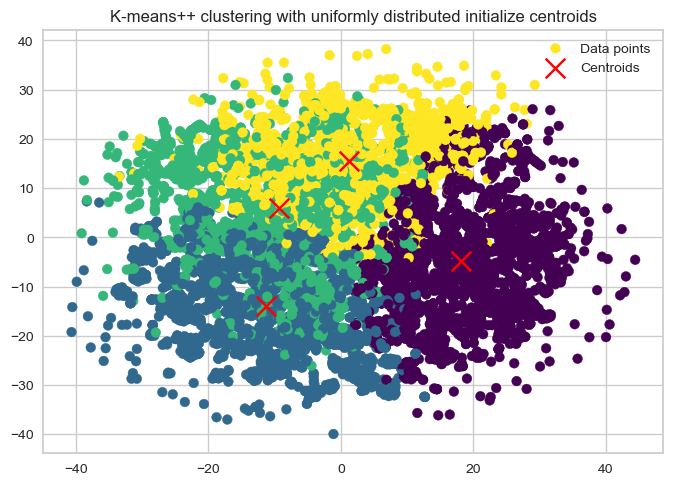

In [37]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def grid_initialize_centroids(df, k):
    # k points uniformly distributed points
    n = len(df)
    grid_points = np.linspace(0, n-1, k).astype(int)
    return df.iloc[grid_points].values

def fixed_initialize_centroids(df, k):
    X =  df.values
    # find the dimension of the min and max columns
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    # equidistant centroids between max and min
    centroids = np.array([np.linspace(min_vals[i], max_vals[i], k) for i in range(X.shape[1])]).T
    return centroids

def kmeans_plus_plus(df, k, max_iters=100):
    centroids = grid_initialize_centroids(df,k)
    prev_centroids = np.zeros_like(centroids)
    # upgrade the centroids
    for i in range(max_iters):
        # Assigne for each point the closest centroid
        distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in df.values])
        closest_centroids = np.argmin(distances, axis=1)
        new_centroids = np.array([df.values[closest_centroids == j].mean(axis=0) for j in range(k)])
        # Control: it ends if the centroids are the same as the previous step
        if np.allclose(new_centroids, centroids):
            print(f"Convergence reached after {i+1} iterations.")
            break
        centroids = new_centroids
    return centroids, closest_centroids


# cluster number
k_cluster = cluster_numbers
centroids, labels = kmeans_plus_plus(df_tsne, k_cluster)

print(f"Final centroids:\n{centroids}")
print(f"Final labels for points:\n{labels[:10]}") 
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels, cmap='viridis', label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label="Centroids")
plt.title("K-means++ clustering with uniformly distributed initialize centroids")
plt.legend()
plt.show()

> ###  Question

Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm.

> ### Answer

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a density-based clustering algorithm that groups points together based on their density. Unlike K-means, DBSCAN doesn't require the user to specify the number of clusters beforehand. It works by identifying areas of high point density and marking low-density areas as outliers (noise).

Pros: can find arbitrarily shaped clusters and handles outliers (noise) well.

Cons: sensitive to the choice of parameters eps (radius of neighborhood) and min_samples (minimum number of points to form a dense region).

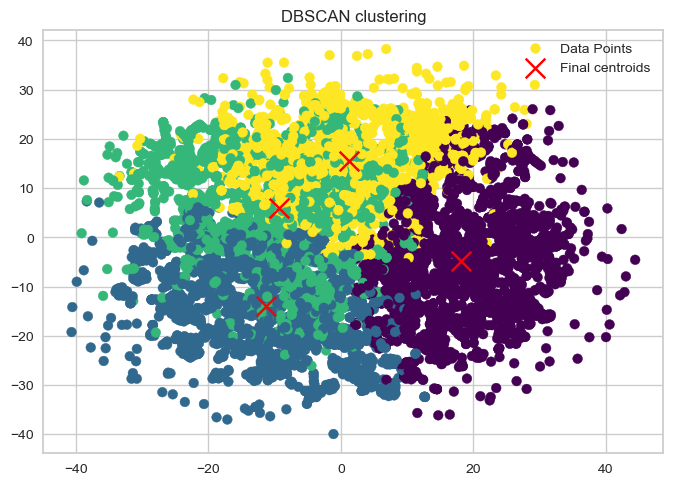

In [38]:
from sklearn.cluster import DBSCAN

# Assuming df_pca is your DataFrame after PCA
db = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples can be tuned
# eps: controls the maximum distance between two samples for them to be considered as in the same neighborhood.
# min_samples: is the number of points required to form a dense region.
db.fit(df_tsne)

# Add the cluster labels to your DataFrame
df_tsne['cluster'] = db.labels_


plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label="Final centroids")
plt.title("DBSCAN clustering")
plt.legend()
plt.show()


>### Question 

Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. 

>### Answer

Hierarchical clustering does not require specifying the number of clusters in advance. Instead, it creates a hierarchy of clusters and you can decide how many clusters you want by "cutting" the tree at a specific level.

### Advantages of Hierarchical Clustering:
1. No need to predefine the number of clusters: One of the major advantages over K-means, as the algorithm produces a hierarchical tree (dendrogram) that allows you to decide the number of clusters after the analysis is complete.
2. Can capture complex cluster shapes: Hierarchical clustering can capture clusters of various shapes, unlike K-means, which assumes spherical clusters.
3. Interpretability: The dendrogram provides a visual representation of the clustering process, which can be insightful for understanding the data.

### Disadvantages of Hierarchical Clustering:
1. Computationally expensive: Hierarchical clustering is much slower than K-means, especially for large datasets, because it requires computing pairwise distances between all data points.
2. Memory intensive: Since it needs to store the pairwise distances between all points, it can be memory-intensive for large datasets.
3. Does not scale well to very large datasets: Due to its computational complexity (O(n²) for agglomerative clustering), it may not be practical for very large datasets.
4. Sensitive to noise and outliers: Just like K-means, hierarchical clustering can be sensitive to noise, and outliers can distort the clustering process.


### Comparison of K-means, K-means++, and Hierarchical Clustering

| **Feature**                      | **K-means**               | **K-means++**             | **Hierarchical Clustering** |
|-----------------------------------|---------------------------|---------------------------|-----------------------------|
| **Initialization**                | Random                    | Improved initialization   | No need to initialize       |
| **Number of clusters (K)**        | Must be specified         | Must be specified         | Can be determined from the dendrogram |
| **Cluster Shape**                 | Spherical/convex          | Spherical/convex          | Can handle arbitrarily shaped clusters |
| **Sensitivity to Outliers**       | High                      | High                      | Moderate to High            |
| **Computational Complexity**      | O(n * K * t)              | O(n * K * t)              | O(n²) for agglomerative     |
| **Scalability**                   | High  (for small to medium datasets) | High (similar to K-means) | Low (doesn't scale well)    |
| **Advantages**                    | Fast, simple              | Better initialization and convergence | Flexible, no need to predefine clusters, captures complex shapes |
| **Disadvantages**                 | Sensitive to initialization, assumes spherical clusters | Same as K-means but with better initialization | Computationally expensive, memory-intensive, sensitive to noise |




 >### Question 

Additionally, ask to implement the algorithm for you or utilize an existing version from a package. 

 >### Answer 



Centroids: [[-1.04791521e+01 -3.05186654e+00  1.14758199e+01 -3.05967889e-01]
 [-8.28427577e+00  5.70257311e+00 -1.42750609e+01 -1.94769711e-01]
 [ 3.49190626e+00 -2.48801582e-02 -3.81762455e-02  8.76978723e+01]
 [ 1.61502158e+01 -9.38546989e-01 -3.81289313e-01 -5.61221550e-01]]
Inertia: 4362659.143967971
Silhouette Score: 0.26094030713988026


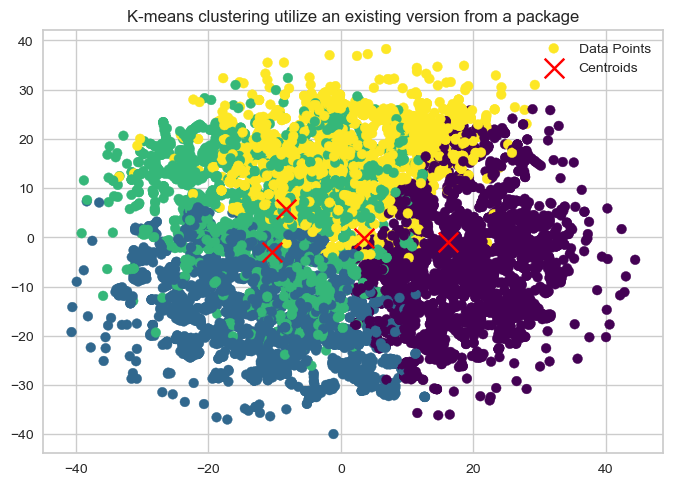

In [39]:
from sklearn.metrics import silhouette_score

# the teps 1 was create the dataframe, but we already have one

# Step 2: Choose the number of clusters (k)
k = cluster_numbers  # Choose the number of clusters

# Step 3: Fit the K-Means model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_tsne)  # Fit the model to the scaled data

# Step 4: Assign clusters
df_tsne['Cluster'] = kmeans.predict(df_tsne)

# Step 5: Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Step 6: Evaluate the clustering (optional)
inertia = kmeans.inertia_  # Within-cluster sum of squares (WSS)
silhouette = silhouette_score(df_tsne, df_tsne['Cluster'])  # Silhouette score

print(f'Centroids: {centroids}')
print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette}')

# Step 7: Visualize the clustering 
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-means clustering utilize an existing version from a package")
plt.legend()
plt.show()

 >###  Question 

Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

>### Answer

They look similar

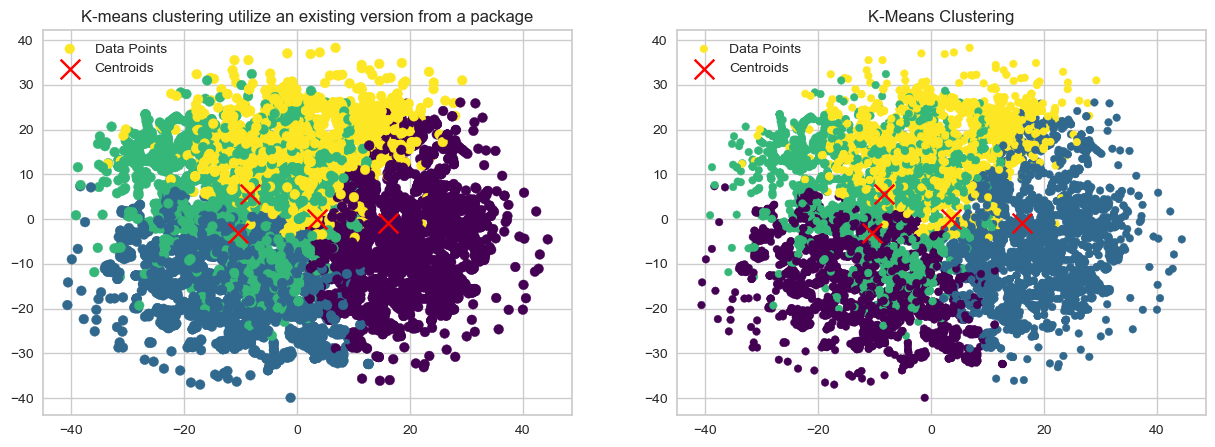

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-means clustering utilize an existing version from a package")
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=30, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-Means Clustering")
plt.legend()

plt.show()

### **2.4 Best Algorithm**

Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.

1. Set the number of clusters to the optimal number $k_{opt}$ based on any of the methods previously.

> From the exercise 3.2.1, we have determined $k_opt = 4$ through the *Elbow Method* as the optimal number to clusterize our dataset.

In [41]:
k_opt = 4

2. Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.


> Metrics to assess the quality of clusters are essential for evaluating how well a clustering algorithm performs. They provide insights on how well the clusters are cohesive and meaningful.

We have chosen three metrics to decide the best algorithm.

#### **Silhouette Score:**   $S= \frac{max(a,b)}{b−a} $
 
The *Silhouette Score* measures how well each point is grouped with its cluster and separated from others.
 
Where:

- $a$: mean distance of a point to points in its own cluster.

- $b$: mean distance of a point to points in the nearest neighboring cluster.

- Ranges from −1 to +1 : values near 1 indicate well-separated clusters.

#### **Davies-Bouldin Index**

The *Davies-Bouldin Index (DB)* measures the ratio of intra-cluster distances (cohesion) to inter-cluster distances (separation).

The formula is defined as:

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d(C_i, C_j)}
$$

Where:
- $k$ is the number of clusters.
- $\sigma_i$ is the average distance of all points in cluster $i$ to the centroid of cluster $i$ (cohesion).
- $d(C_i, C_j)$ is the distance between the centroids of clusters $i$ and $j$ (separation).
- The **max** operator ensures that for each cluster $i$, we consider the cluster $j$ with the worst (largest) ratio.

A **lower** DB index indicates better clustering performance.

#### **Calinski-Harabasz Index**

The *Calinski-Harabasz Index* is a metric used to evaluate the quality of clustering. 
It assesses the **separation** and **cohesion** of the clusters by comparing the within-cluster dispersion to the between-cluster dispersion. 

The formula is:

$$
CH = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \times \frac{n - k}{k - 1}
$$

Where:

- $\text{tr}(B_k)$ is the **trace of the between-cluster dispersion matrix**.
- $\text{tr}(W_k)$ is the **trace of the within-cluster dispersion matrix**.
- $n$ is the total number of samples (data points).
- $k$ is the number of clusters.
- *Between-cluster dispersion matrix $B_k$*: Measures the variance between the cluster centroids and the overall centroid.
- *Within-cluster dispersion matrix $W_k$*: Measures the variance within each cluster.

A **higher** value of the Calinski-Harabasz index indicates better clustering performance, meaning the clusters are more distinct and more cohesive.

___
3. Apply the three clustering algorithms used in the prior section to partition the data into $k_{opt}$ clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.


> To compare the quality of the 3 algorithms implemented above, we use the scores just defined.

- In the following cell, we loop over the dictionary of algorithms we initialize with the 3 algos defined in the 2.3 

- Then, we compute for each algo the 3 metrics using the dataset and the labels returned by each algo

- In the end we define a *lineplot* representing the 3 metrics for each algo

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

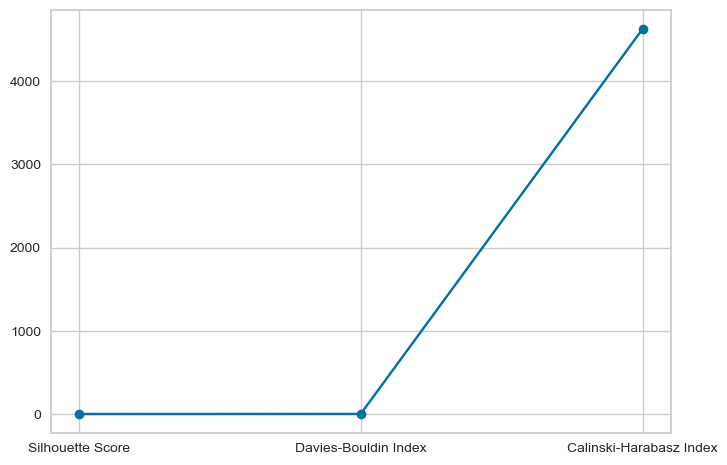

In [ ]:

clustering_algorithms = {
    "K-Means": k_means, 
    "K-Means++": kmeans_plus_plus
    # ADD the Others
}
results = {}

X = df_tsne.values
for name, clustering_function in clustering_algorithms.items():
    centroids, labels = clustering_function(X, k_opt)
    # Compute the scores to evaluate the clustering algorithm
    silhouette = silhouette_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    
    # Saves the scores for the algorithm
    results[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies,
        "Calinski-Harabasz Index": calinski
    }
    # Plot the scores for the current algorithm
    plt.plot(["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"],
             [silhouette, davies, calinski], marker='o', label=name)

# Add titles and labels
plt.title('Clustering Algorithm Evaluation Metrics')
plt.xlabel('Clustering Metrics')
plt.ylabel('Score')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()



## **Bonus Question**
___
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

1. Select two variables from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

## **4. Algorithmic Question**

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of `nums`, is laid out in front of them. Arya will start by selecting either the number at the beginning (`nums[0]`) or the end (`nums[nums.length - 1]`) of the array, adding that value to her score. This value is then removed from the beginning or the end of `nums`. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.



- a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).


### **Function** `predict_arya_can_win(nums)`

**Input:**  
- `nums`: A list of integers representing the numbers available for Arya and Mario to choose.

**Output:**  
- Returns `True` if Arya can guarantee a win (or tie), otherwise `False`.

### **Steps**  

#### **Inner Function** `max_score(i, j, turn)`
1. **Base Case**:  
   If `i > j`, return `0` (no numbers left to choose).

2. **Check Memory**:  
   If `memory[i][j]` is not `None`, return the stored result.

3. **Arya's Turn (`turn == 1`)**:
   - Compute both options:  
     - `choose_start = nums[i] + max_score(i + 1, j, 2)`  
     - `choose_end = nums[j] + max_score(i, j - 1, 2)`
   - Result: `result = max(choose_start, choose_end)`.

4. **Mario's Turn (`turn == 2`)**:
   - Compute both options:  
     - `choose_start = max_score(i + 1, j, 1)`  
     - `choose_end = max_score(i, j - 1, 1)`
   - Result: `result = min(choose_start, choose_end)`.

5. **Store Result**:  
   Store the result in `memory[i][j]`.

6. **Return**:  
   Return `result`.

#### **Main Function Logic**

1. Initialize variables:
   - `n = len(nums)`  
   - `memory = [[None] * n for _ in range(n)]`  

2. Calculate total score:  
   `total_score = sum(nums)`  

3. Find Arya's optimal score:  
   `arya_score = max_score(0, n - 1, 1)`  

4. Return result:  
   `return arya_score >= (total_score - arya_score)`  




- b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.


In [ ]:
def predict_arya_can_win(nums):
    n = len(nums)
    memory = [[None] * n for _ in range(n)]

    def max_score(i, j, turn):
        if i > j:
            return 0
        if memory[i][j] is not None:
            return memory[i][j]

        if turn == 1:  # Arya's turn
            choose_start = nums[i] + max_score(i + 1, j, 2)
            choose_end = nums[j] + max_score(i, j - 1, 2)
            result = max(choose_start, choose_end)
        else:  # Mario's turn
            choose_start = max_score(i + 1, j, 1)
            choose_end = max_score(i, j - 1, 1)
            result = min(choose_start, choose_end)

        memory[i][j] = result
        return result

    total_score = sum(nums)
    arya_score = max_score(0, n - 1, 1)
    return arya_score >= (total_score - arya_score)



In [ ]:
#test

print(predict_arya_can_win([8, 5, 7])) #output: true
print(predict_arya_can_win([1, 5, 2]))  # Output: false
print(predict_arya_can_win([1, 5, 233, 7]))  # Output: true

True
False
True



- c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.




### **Is the algorithm efficient?**

* The algorithm uses **recursion with memoization** to avoid redundant computations, making it efficient for the problem at hand.

### **Time Complexity Analysis**

#### **Step-by-Step Complexity**

1. **Recursive Calls**: 
   - The function `max_score(i, j, turn)` is called for every possible pair `(i, j)` where `i <= j`.
   - The range of `i` and `j` spans from `0` to `n - 1`, creating a total of `O(n^2)` unique subproblems.
   
2. **Memoization**: 
   - For each pair `(i, j)`, the result is computed once and stored in the `memory` array.
   - Each computation involves evaluating two choices (`choose_start` and `choose_end`), which are constant-time operations.

3. **Overall Complexity**:
   - Solving each of the `O(n^2)` subproblems takes **constant time**, leading to a **total time complexity of O(n^2)**.

### **Space Complexity Analysis**

1. **Memory Array**:
   - A 2D array `memory` of size `n x n` is used to store intermediate results. This requires `O(n^2)` space.

2. **Call Stack**:
   - The maximum depth of the recursion is `O(n)` (in the worst case, the array shrinks by one element at each step).

3. **Overall Space Complexity**:
   - The algorithm requires `O(n^2)` space for the `memory` array and `O(n)` space for the call stack.
   - **Total space complexity: O(n^2)**.

### **Asymptotic Complexity**

#### **Time Complexity**:  
- **O(n^2)**  
  The algorithm is **polynomial in time**, as it solves `O(n^2)` subproblems with constant-time operations per subproblem.

#### **Space Complexity**:  
- **O(n^2)**  
  The space complexity is driven by the memoization table.


### **Why This Algorithm Is Efficient**

Without memoization, the algorithm would explore all possible game states, leading to an complex ecponencial problem of `O(2^n)` (choosing between `start` and `end` at each step). However, memoization ensures that each subproblem is solved only once, reducing the complexity.

### **Python-Style Code Complexity Bound**

Recursive calls to `max_score(i, j, turn)`:
- i ranges from 0 to n-1
- j ranges from i to n-1
- total subproblems = O(n^2)

Also, each subproblem involves constant-time computations:
- 2 recursive calls (choose_start and choose_end)
- Maximum or minimum operation
- The total time complexity = O(n^2) and the memory array size = n x n




- d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.



### **Function** `predict_arya_can_win_dp(nums)` using a dynamic programming (DP) approach
**Input:**  
- `nums`: A list of integers representing the sequence.

**Output:**  
- Returns `True` if Arya can guarantee a win (or tie), otherwise `False`.

#### **Steps**  

1. **Initialize Variables**:  
   - `n = len(nums)`  
   - Create a 2D DP table `dp` of size `n x n`, initialized to `0`.

2. **Base Case**:  
   - For subarrays of length 1 (single element):  
     ```python
     for i in range(n):
         dp[i][i] = nums[i]  # supposing that Arya picks the only available number
     ```

3. **Iterative DP Table Filling**:  
   - For subarrays of increasing lengths (from 2 to `n`):  
     ```python
     for length in range(2, n + 1):  
         for i in range(0, n - length + 1): 
             j = i + length - 1  
             choose_start = nums[i] + min(dp[i + 1][j - 1], dp[i + 2][j])   
             choose_end = nums[j] + min(dp[i][j - 2], dp[i + 1][j - 1])     
             dp[i][j] = max(choose_start, choose_end)
     ```

4. **Compute Arya's Optimal Score**:  
   - `arya_score = dp[0][n - 1]`  

5. **Calculate Total Score**:  
   - `total_score = sum(nums)`

6. **Return Result**:  
   - Arya wins if her score is at least half of the total score:  
     ```python
     return arya_score >= (total_score - arya_score)
     ```

#### **Complexity**

##### Time Complexity:  
- **Outer loop** (`length`): Runs \( O(n) \) times.  
- **Inner loop** (`i`): Runs \( O(n) \) for each length.  
- Each DP cell computation takes constant time.  

**Total time complexity**: \( O(n^2) \).

##### Space Complexity:  
- DP table `dp` of size \( O(n^2) \).  

**Total space complexity**: \( O(n^2) \).




- e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.


In [ ]:
## Implementation of the Algorithm DP with Python

def predict_arya_can_win_dp(nums):
    n = len(nums)
    dp = [[0] * n for _ in range(n)]
    
    for i in range(n):
        dp[i][i] = nums[i] 
    
    for length in range(2, n + 1):  
        for i in range(n - length + 1):
            j = i + length - 1  
            
            choose_start = nums[i] + min(dp[i + 1][j - 1] if j - 1 >= i + 1 else 0, dp[i + 2][j] if i + 2 <= j else 0)
            choose_end = nums[j] + min(dp[i][j - 2] if j - 2 >= i else 0, dp[i + 1][j - 1] if i + 1 <= j - 1 else 0)
            dp[i][j] = max(choose_start, choose_end)
    
    arya_score = dp[0][n - 1]
    total_score = sum(nums)
    
   
    return arya_score >= (total_score - arya_score)


In [ ]:
#test

print(predict_arya_can_win_dp([8, 5, 7])) #output: true
print(predict_arya_can_win_dp([1, 5, 2]))  # Output: false
print(predict_arya_can_win_dp([1, 5, 233, 7]))  # Output: true

True
False
True


For both algoritms, we got the same results for the tests that we did. However, what may be different about them is the performance. So, here is a running test for both algorithms

In [ ]:
import time

large_test_case = list(range(1, 100))

# measure DP algorithm runtime
start = time.time()
predict_arya_can_win_dp(large_test_case)
end = time.time()
print(f"Dynamic Programming Time: {end - start:.6f} seconds")

# measure recursive algorithm runtime
start = time.time()
predict_arya_can_win(large_test_case)
end = time.time()
print(f"Recursive Memoized Time: {end - start:.6f} seconds")


Dynamic Programming Time: 0.016687 seconds
Recursive Memoized Time: 0.012310 seconds


The running times between both algorithms are very similar and only have a small difference of 0,0043 seconds. 


- f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

ChatGPT suggested a third optimied implementation that aim to reduce nnecessary memory usage and overhead while maintaining `𝑂(𝑛2)` complexity. However, instead of using full `𝑛 × n` DP table, the AI suggested a space-optimized Dynamic Programming approach. Since each state only depends on states from the previous row or column, a maintainance of only one or two arrays to store intermediate results can be created

In [ ]:
## Implementation of the optimied algotithm by ChatGPT

def predict_arya_can_win_optimized(nums):
    n = len(nums)
    
    # Step 1: Initialize a single array for DP results of the current row
    dp = nums[:]  # Start with the base case: one-element subarrays
    
    # Step 2: Fill DP table for increasing subarray lengths
    for length in range(2, n + 1):  # Subarray lengths
        for i in range(n - length + 1):  # Starting index
            j = i + length - 1  # Ending index
            # Arya's choices
            choose_start = nums[i] - dp[i + 1]  # If Arya chooses nums[i]
            choose_end = nums[j] - dp[i]       # If Arya chooses nums[j]
            dp[i] = max(choose_start, choose_end)
    
    # Step 3: Final result
    return dp[0] >= 0


In [ ]:
#test

print(predict_arya_can_win_optimized([8, 5, 7])) #output: true
print(predict_arya_can_win_optimized([1, 5, 2]))  # Output: false
print(predict_arya_can_win_optimized([1, 5, 233, 7]))  # Output: true

True
False
True


We got the same results as with the other two algorithms, so we have to check the running time...where we supposed there are going to be the most efficient changes

In [ ]:
import time

large_test_case = list(range(1, 100))

# measure optimized algorithm runtime
start = time.time()
predict_arya_can_win_optimized(large_test_case)
end = time.time()
print(f"Optimized Programming Time: {end - start:.6f} seconds")

Optimized Programming Time: 0.003541 seconds


While the first two algorithms got a very similar time, this optimied algorithm has reduced the running time to 0.0035 seconds. Let's check the performance of the algorithm

In [ ]:
import time
import statistics


large_test_case = list(range(1, 200))  
num_iterations = 5

# Measure Optimized Algorithm runtime
optimized_times = []
for _ in range(num_iterations):
    start = time.time()
    predict_arya_can_win_optimized(large_test_case)
    optimized_times.append(time.time() - start)

# Output results
print(f"Optimized DP Avg Time: {statistics.mean(optimized_times):.6f} seconds")


Optimized DP Avg Time: 0.010946 seconds


The optimized implementation uses less memory and performed slightly faster due to reduced memory overhead, though the runtime remains `𝑂(𝑛2)`. However, the main difference was to instead of maintaining a full DP table, the optimied algorithm tracked only the scores Arya can achieve for subarrays ending at different indices, reusing and overwriting values in the array dp as we iterate. We can consider ChatGPT is doing a good job because managed to keep the same time complexity of `𝑂(𝑛2)`, but with a space-efficient version that is suitable for solving larger instances of the problem due to its lower memory requirements. And, it maintains the same accuracy and theoretical runtime as the original DP solution.